In [2]:

%load_ext autoreload
%autoreload 2
import networkx as nx
import matplotlib.pyplot as plt
import random
#from pcc_implementacao import *
import pandas as pd
import plotly.express as px
from sklearn.neighbors import NearestNeighbors
import numpy as np

from model import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Particle competition for complex network community detection
### Summary of the Process  
1. Initialization: Start with several particles placed randomly in the network, each with low potential.  
2. Iteration: In each step, particles choose a neighboring node to visit based in a mix of random and deterministic rules.  
3. Update Ownership: Depending on the visit outcome, update the ownership and potential of both the particle and the node.  
4. Convergence: Repeat the process until each community is owned by a single particle, indicating successful community detection.  


# Inicialização

2. Criação de uma rede aleatória clusterizada

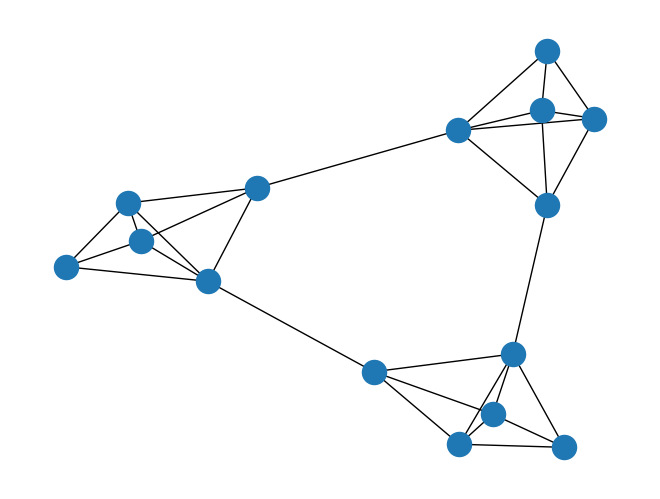

In [3]:
G_test = nx.connected_caveman_graph(3, 5)
nx.draw(G_test)

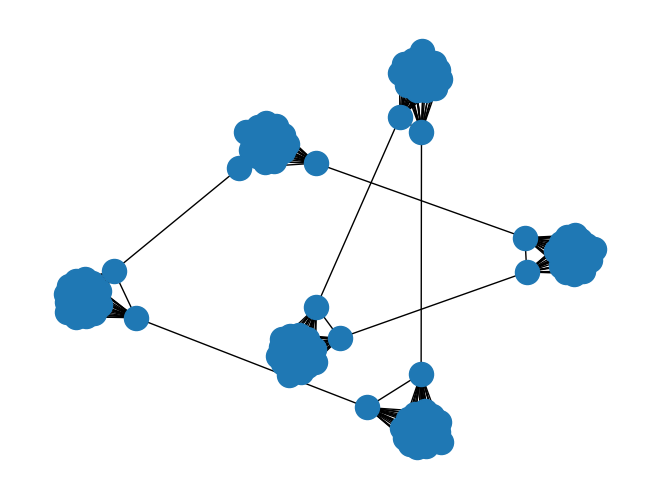

In [4]:
G_test = nx.connected_caveman_graph(6, 20)
nx.draw(G_test)

# Dataset

In [5]:
df_sar = pd.read_csv('data/sar_dataset.csv')
df_sar

,feature_1,feature_2,true_label,observed_label
0,1.496714,0.861736,positive,0
1,1.647689,2.523030,positive,0
2,0.765847,0.765863,positive,1
3,2.579213,1.767435,positive,0
4,0.530526,1.542560,positive,1
5,0.536582,0.534270,positive,0
6,1.241962,-0.913280,positive,1
7,-0.724918,0.437712,positive,0
8,-0.012831,1.314247,positive,0
9,0.091976,-0.412304,positive,0


In [6]:
px.scatter(df_sar, x = 'feature_1', y = 'feature_2', color = 'true_label')

# Graph Creation

In [7]:
# Choose the number of neighbors (k)
k = 3

Graph created with k=3
Number of nodes: 40
Number of edges: 81


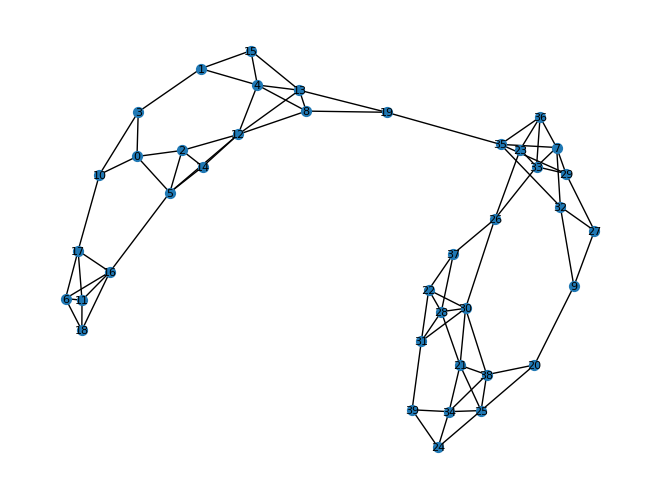

In [8]:
# --- 1. Define Nodes ---
# Nodes will correspond to the index of the dataframe rows
nodes = df_sar.index

# --- 2. Calculate Neighbors ---
# Select the features to calculate distance
features = df_sar[['feature_1', 'feature_2']].values


# We ask for k+1 neighbors because the point itself is always the closest (distance 0)
nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='ball_tree').fit(features)
distances, indices = nbrs.kneighbors(features)

# --- 3. Define Edges ---
# Create an edge list based on k-NN
# indices[i, 0] is always node i itself, so we start from indices[i, 1]
edge_list = []
for i in range(len(features)):
    for j_idx in range(1, k + 1): # Iterate through the k nearest neighbors (excluding self)
        neighbor_index = indices[i, j_idx]
        # Add edge (i, neighbor_index) - ensure order doesn't matter for undirected graph
        # We can add edges in both directions initially and NetworkX handles duplicates
        edge_list.append(tuple(sorted((i, neighbor_index))))


# Remove duplicate edges by converting to a set
unique_edges = set(edge_list)

# --- 4. Build Graph ---
# Create an empty graph
G = nx.Graph()

# Add nodes
G.add_nodes_from(nodes)

# Add edges
G.add_edges_from(unique_edges)

# Optional: Add features/labels as node attributes
# Convert labels to string type if they aren't already, for compatibility
attributes = df_sar.to_dict('index') # Get attributes for each node (row index)
nx.set_node_attributes(G, attributes)
print(f"Graph created with k={k}")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

nx.draw(G, with_labels=True, node_size=50, font_size=8)
plt.savefig("graph_dataset.png", dpi=600)

# Execução

All conditions met. Stopping simulation.


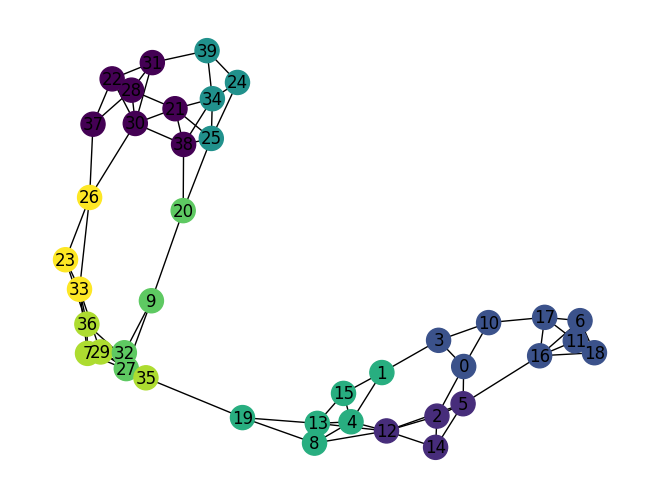

In [56]:
p_det = 0.4
M = 10 # number of particles
delta_p = 0.1
delta_v = 0.1


PCM = ParticleCompetitionModel(G, M,  p_det, delta_p, delta_v)
g_sim = PCM.run_simulation(2000)
PCM.visualize_communities(g_sim)

In [57]:
PCM.graph_without_owners()

False

In [58]:
PCM.check_average_node_potential()[1]

np.False_

In [59]:
PCM._check_positive_cluster_existence()

True

In [11]:
p_det = 0.6  # Probability of deterministic movement
# iterations = 100 # Number of iterations
M = 10
G_sim, parts = run_simulation(G, M, 0.4, 0.1, 0.1)
assign_cluster_labels(G_sim, df_sar)
df_sar.groupby('cluster')['observed_label'].apply(list).to_dict()


{0.0: [0, 0, 0],
 1.0: [0, 0, 0],
 2.0: [0],
 3.0: [0, 0, 0],
 4.0: [0, 0],
 5.0: [1, 0, 1],
 6.0: [0, 0, 0],
 7.0: [0, 0],
 8.0: [0],
 9.0: [0]}

In [12]:
assign_owner_cluster_feature(G_sim)
calculate_dissimilarity(G_sim)
rank_nodes_dissimilarity(G_sim, 20)

[(39, 12),
 (21, 11),
 (22, 11),
 (24, 11),
 (28, 11),
 (31, 11),
 (34, 11),
 (25, 10),
 (30, 10),
 (37, 10),
 (38, 10),
 (20, 9),
 (26, 9),
 (9, 8),
 (23, 8),
 (27, 8),
 (33, 8),
 (7, 7),
 (29, 7),
 (32, 7)]

In [13]:
owner_groups = defaultdict(list)
for node in G_sim.nodes:
    owner = G_sim.nodes[node]['data'].owner
    owner_groups[owner].append(node)
owner_groups

defaultdict(list,
            {None: [0,
              3,
              6,
              8,
              13,
              14,
              16,
              18,
              20,
              23,
              24,
              26,
              29,
              33,
              34,
              35,
              36,
              39],
             0: [1, 4, 15],
             3: [2, 5, 12],
             6: [7, 19, 32],
             7: [9, 27],
             5: [10, 11, 17],
             9: [21],
             4: [22, 30],
             2: [25],
             1: [28, 37, 38],
             8: [31]})